# 10 minutes to cuxfilter

This is a short introduction to the cuxfilter.py library, mostly going over the basic usage and features provided as a quick summary.

### What is cuxfilter?

cuxfilter is inspired from the Crossfilter library, which is a fast, browser-based filtering mechanism across multiple dimensions and offers features do groupby operations on top of the dimensions. One of the major limitations of using Crossfilter is that it keeps data in-memory on a client-side browser, making it inefficient for processing large datasets.

cuxfilter solves the issues by leveraging the power of the rapids.ai stack, mainly cudf. The data is maintained in a gpu as a GPU DataFrame and operations like groupby aggregations, sorting and querying are done on the gpu itself, only returning the result as the output to the charts.

cuxfilter acts as a `connector` library, which provides the connections between different visualization libraries and a GPU dataframe without much hassle. This also allows the user to use charts from different libraries in a single dashboard, while also providing the interaction.

cuxfilter uses data-tiles on the front-end, which are precomputed aggregations, for all possible interactions for a single chart, for updating all remaining charts in a dashboard. data-tiles are just smartly computed groupbys, and generally take around 250ms per chart for a 100M row dataset(do the rest of the math!!!!, ps: its fast!). Once it's downloaded, interactions are seamless, and well, realtime.

### The modules

> cuxfilter has following usable modules

1. cuxfilter.DataFrame
2. cuxfilter.DashBoard
3. cuxfilter.charts
4. cuxfilter.layouts
5. cuxfilter.themes
6. cuxfilter.assets

### Usage

#### 1. Import the required modules

In [5]:
import cuxfilter
from cuxfilter import DataFrame, themes, layouts
from cuxfilter.assets.custom_tiles import get_provider, Vendors

#### 2. Read some data

> cuxfilter can read arrow files off disk, or an inmemory cudf dataframe

In [4]:
#create cuxfilter DataFrame
cux_df = DataFrame.from_arrow('../../data/auto_accident_loc_data.arrow')
cux_df.data['ST_CASE'] = cux_df.data['ST_CASE'].astype('float64')
cux_df.data.head()

STATE  ST_CASE  VEH_NO  PER_NO  COUNTY  CITY  DAY  MONTH  YEAR  DAY_WEEK  \
0      1  10001.0       1       1     831   968   19      2  2017         1   
1      1  10002.0       1       1    1009  5923   14      2  2017         3   
2      1  10003.0       1       1    1120  8314   31      1  2017         3   
3      1  10003.0       2       1    1120  8314   31      1  2017         3   
4      1  10003.0       3       1    1120  8314   31      1  2017         3   

   ...  ROUTE  RELJCT2  AGE  LAG_HRS  ALC_RES  UNITS_SOLD   LATITUDE  \
0  ...      1        1   42        0     0.96    186161.0  33.335661   
1  ...      1        1   43        0     0.00    150219.0  34.661528   
2  ...      1        1   63      999     0.00         0.0  32.366519   
3  ...      1        1   47        0     0.00    207479.0  32.366519   
4  ...      1        1   64      999     0.96         0.0  32.366519   

    LONGITUD     dropoff_x     dropoff_y  
0 -87.007094 -9.685585e+06  3.939943e+06  
1 -86.786853 -9.661068e+06  4.117979e+06  
2 -86.145281 -9.589649e+06  3.811519e+06  
3 -86.145281 -9.589649e+06  3.811519e+06  
4 -86.145281 -9.589649e+06  3.811519e+06  

[5 rows x 63 columns]

#### 3. Create some charts

> see charts section to see available chart options

In [6]:
demo_red_blue_palette = [ (49,130,189), (107,174,214), (123, 142, 216), (226,103,152), (255,0,104) , (50,50,50) ]

chart1 = cuxfilter.charts.datashader.scatter_geo(x='dropoff_x', y='dropoff_y', aggregate_col='ST_CASE',
                                         color_palette=demo_red_blue_palette)
chart2 = cuxfilter.charts.bokeh.bar('YEAR')

#creating a label map for days of week strings
label_map = {
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday',
    9: 'Unknown'
}

chart3 = cuxfilter.charts.panel_widgets.multi_select('DAY_WEEK', label_map=label_map)


charts_list = [chart1, chart2, chart3]

#### 4. Create a dashboard object 

In [7]:
d = cux_df.dashboard(charts_list, title='Custom dashboard', layout=layouts.feature_and_base, theme=themes.light, data_size_widget=True)

#### 5. View the dashboard

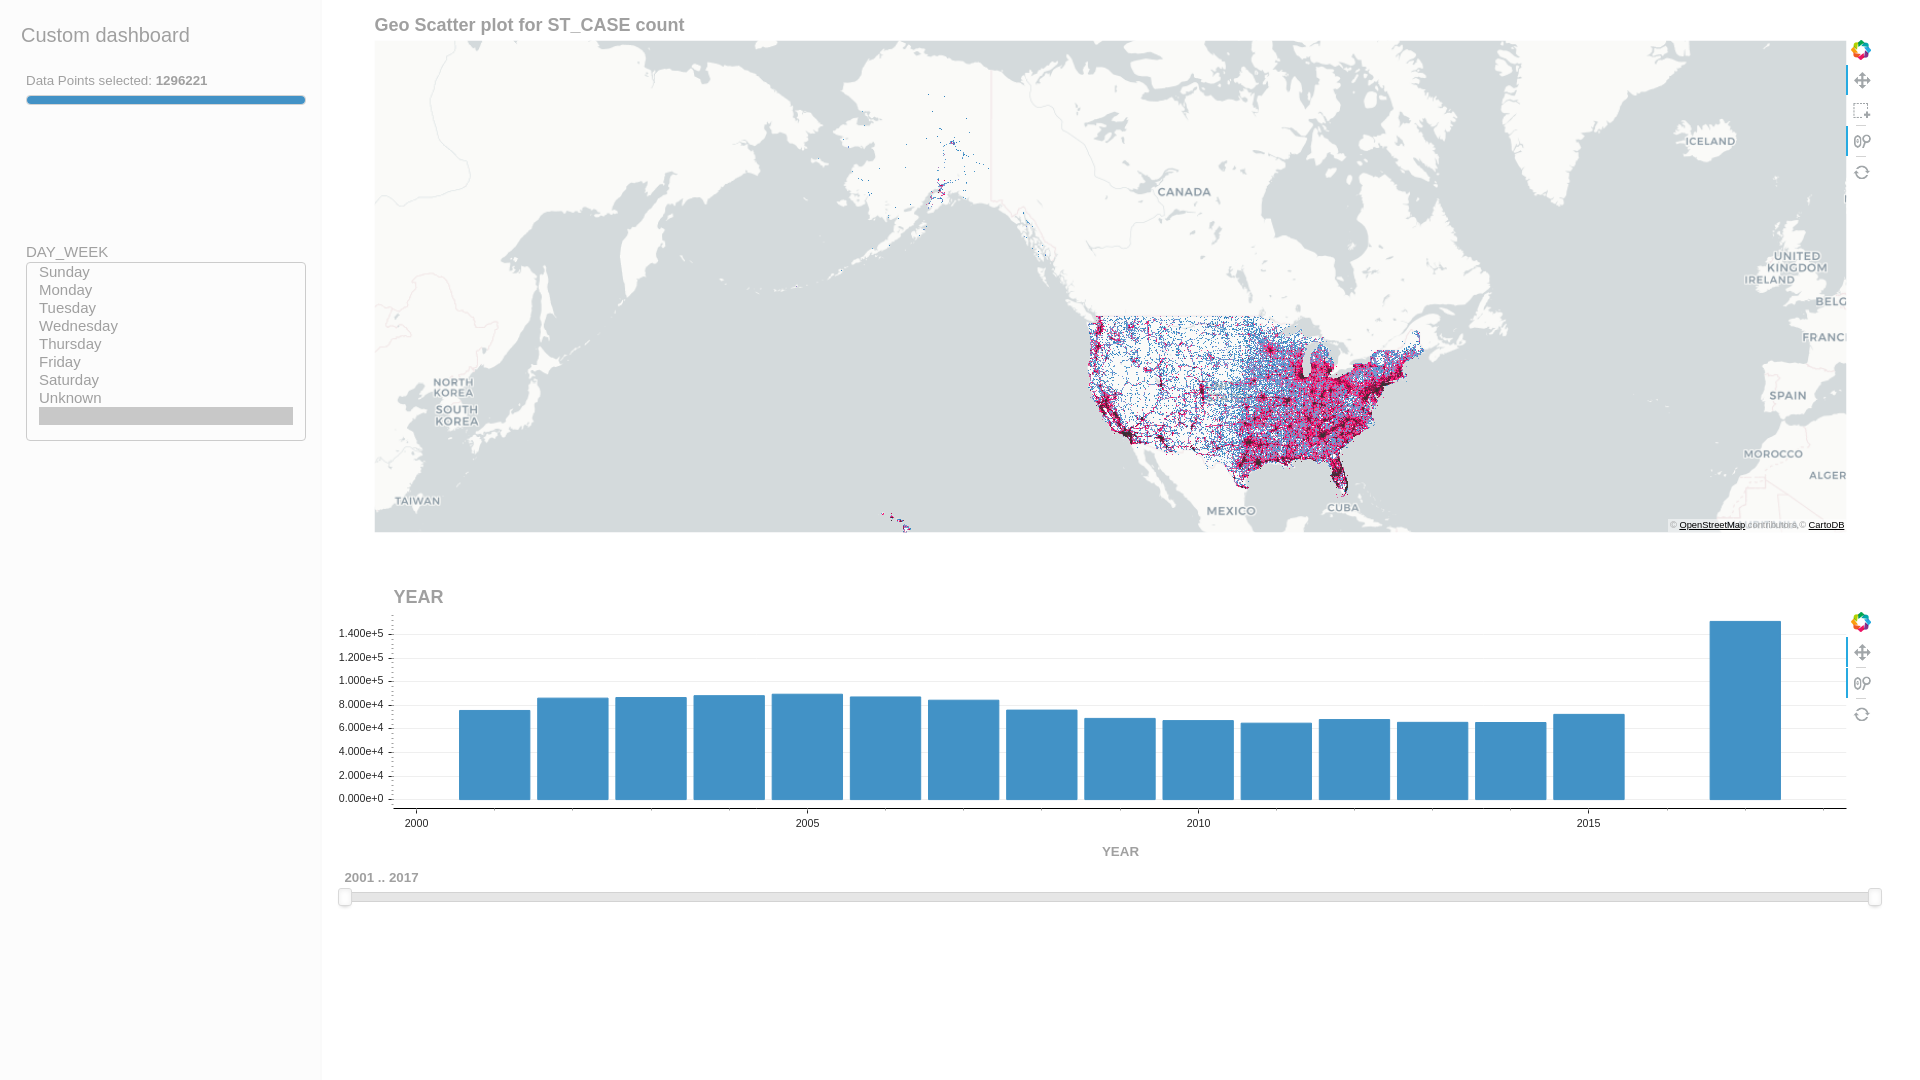

In [8]:
#preview
await d.preview()

#for using the interactive web-app version, use d.app() for in notebook, and d.show() for using it in a separate window as a web-app

#### 6. Run the dashboard

In [9]:
"""
1. d.show('current_notebook_url:current_notebook_port') remote dashboard

2. d.app('current_notebook_url:current_notebook_port') inline in notebook (layout is ignored, and charts are displayed one below another)

Incase you need to stop the server:

- d.stop()
"""

d.show('notebook_url')

Dashboard running at http://notebook_url/proxy/52563/


#### 6. After you do some interactions, you can take a snapshot of the current state and save it as a dataframe!

In [10]:
current_state_df = d.export()

no querying done, returning original dataframe


In [11]:
current_state_df

STATE   ST_CASE  VEH_NO  PER_NO  COUNTY  CITY  DAY  MONTH  YEAR  \
0            1   10001.0       1       1     831   968   19      2  2017   
1            1   10002.0       1       1    1009  5923   14      2  2017   
2            1   10003.0       1       1    1120  8314   31      1  2017   
3            1   10003.0       2       1    1120  8314   31      1  2017   
4            1   10003.0       3       1    1120  8314   31      1  2017   
...        ...       ...     ...     ...     ...   ...  ...    ...   ...   
3891287     56  560154.0       1       2    1609     0   29     12  2001   
3891288     56  560154.0       1       3    1609     0   29     12  2001   
3891289     56  560154.0       1       4    1609     0   29     12  2001   
3891290     56  560154.0       1       5    1609     0   29     12  2001   
3891291     56  560154.0       1       6    1609     0   29     12  2001   

         DAY_WEEK  ...  ROUTE  RELJCT2  AGE  LAG_HRS  ALC_RES  UNITS_SOLD  \
0               1  ...      1        1   42        0     0.96    186161.0   
1               3  ...      1        1   43        0     0.00    150219.0   
2               3  ...      1        1   63      999     0.00         0.0   
3               3  ...      1        1   47        0     0.00    207479.0   
4               3  ...      1        1   64      999     0.96         0.0   
...           ...  ...    ...      ...  ...      ...      ...         ...   
3891287         7  ...      1        1   29        0     0.96         0.0   
3891288         7  ...      1        1   10      999     0.96         0.0   
3891289         7  ...      1        1    9      999     0.96         0.0   
3891290         7  ...      1        1    7      999     0.96         0.0   
3891291         7  ...      1        1    4      999     0.96         0.0   

          LATITUDE    LONGITUD     dropoff_x     dropoff_y  
0        33.335661  -87.007094 -9.685585e+06  3.939943e+06  
1        34.661528  -86.786853 -9.661068e+06  4.117979e+06  
2        32.366519  -86.145281 -9.589649e+06  3.811519e+06  
3        32.366519  -86.145281 -9.589649e+06  3.811519e+06  
4        32.366519  -86.145281 -9.589649e+06  3.811519e+06  
...            ...         ...           ...           ...  
3891287  41.717372 -107.776083 -1.199758e+07  5.118737e+06  
3891288  41.717372 -107.776083 -1.199758e+07  5.118737e+06  
3891289  41.717372 -107.776083 -1.199758e+07  5.118737e+06  
3891290  41.717372 -107.776083 -1.199758e+07  5.118737e+06  
3891291  41.717372 -107.776083 -1.199758e+07  5.118737e+06  

[1296221 rows x 63 columns]